In [ ]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.preprocessing import OneHotEncoder

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
train_df = pd.read_csv("/content/drive/MyDrive/Project/Indian Sign Language/csv_data_file/train.csv")
test_df = pd.read_csv("/content/drive/MyDrive/Project/Indian Sign Language/csv_data_file/test.csv")

In [ ]:
test = pd.read_csv("/content/drive/MyDrive/Project/Indian Sign Language/csv_data_file/test.csv")
y = test['label']

In [ ]:
def change_label(row):
    label = row['label']
    # Determine weather condition
    if label == 'a':
        change = 1 # a
    elif label == 'b':
        change = 2 # b
    elif label == 'c':
        change = 3 # c
    elif label == 'd':
        change = 4 # d
    elif label == 'empty':
        change = 0 # empty

    return change

In [ ]:
# Apply the function to each row of the DataFrame
train_df['label'] = train_df.apply(change_label, axis=1)
test_df['label'] = test_df.apply(change_label, axis=1)

In [ ]:
y_train = train_df['label']
y_test = test_df['label']
y_debug = y_train[0:10]
del train_df['label']
del test_df['label']

In [ ]:
print(y_train)

0      1
1      4
2      0
3      1
4      2
      ..
441    3
442    0
443    0
444    3
445    0
Name: label, Length: 446, dtype: int64


In [ ]:
train_df.shape

(446, 1600)

In [ ]:
from sklearn.preprocessing import LabelBinarizer
label_binarizer = LabelBinarizer()
y_train = label_binarizer.fit_transform(y_train)
y_test = label_binarizer.fit_transform(y_test)

In [ ]:
x_train = train_df.values
x_test = test_df.values

In [ ]:
# Convert y_train and y_test to numpy arrays if they are pandas Series
if isinstance(y_train, pd.Series):
    y_train = y_train.to_numpy()
if isinstance(y_test, pd.Series):
    y_test = y_test.to_numpy()

In [ ]:
# One-hot encode the labels
encoder = OneHotEncoder(sparse=False)

In [ ]:
# Reshape y_train and y_test for encoding
y_train_flat = y_train.reshape(-1, 1)
y_test_flat = y_test.reshape(-1, 1)

y_train_encoded = encoder.fit_transform(y_train_flat)
y_test_encoded = encoder.transform(y_test_flat)

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [ ]:
# Reshape x_train and x_test to 4D tensors if they are not already
if len(x_train.shape) == 2:  # If the shape is (num_samples, height*width)
    x_train = x_train.reshape(x_train.shape[0], 40, 40, 1)
if len(x_test.shape) == 2:  # If the shape is (num_samples, height*width)
    x_test = x_test.reshape(x_test.shape[0], 40, 40, 1)

In [ ]:
print("Shape of y_train_encoded:", y_train_encoded.shape)
print("Shape of y_test_encoded:", y_test_encoded.shape)
print("Shape of x_train:", x_train.shape)
print("Shape of x_test:", x_test.shape)

Shape of y_train_encoded: (2230, 2)
Shape of y_test_encoded: (560, 2)
Shape of x_train: (446, 40, 40, 1)
Shape of x_test: (112, 40, 40, 1)


In [ ]:
print("Shape of x_train:", x_train.shape)
try:
    reshaped_array = x_train.reshape(-1, 40, 40, 1)
    print("Shape of the reshaped array:", reshaped_array.shape)
except ValueError as e:
    print("Error:", e)

Shape of x_train: (446, 40, 40, 1)
Shape of the reshaped array: (446, 40, 40, 1)


In [ ]:
x_tmp = x_train[0]
x_tmp=x_tmp.reshape(1,40,40,1)
x_tmp = np.array(x_tmp)
x_tmp.shape

(1, 40, 40, 1)

In [ ]:
np.transpose(y_debug).shape

(10,)

In [ ]:
# I will use this for debuggin on the ESP32
x_debug = (train_df.values)[0:10]
csv_x_debug = 'csv_x.csv'
csv_y_debug = 'csv_y.csv'
y_db2 = np.array(y_debug).reshape(1,-1)
# Write data to the CSV file
np.savetxt(csv_x_debug, x_debug, delimiter=',', fmt='%s')
np.savetxt(csv_y_debug, y_db2, delimiter=',', fmt='%s')

In [ ]:
# Normalize the data
x_train = (x_train  / 127.5) - 1.0
x_test = (x_test/127.5)-1.0# - 128 # / 255

In [ ]:
print(x_train.shape)
print(x_train.size)

(446, 40, 40, 1)
713600


In [ ]:
print(x_test.shape)
print(x_test.size)

(112, 40, 40, 1)
179200


In [ ]:
x_train = x_train.reshape(-1, 40, 40, 1)
x_test = x_test.reshape(-1, 40, 40, 1)

In [ ]:
x_train.shape

(446, 40, 40, 1)

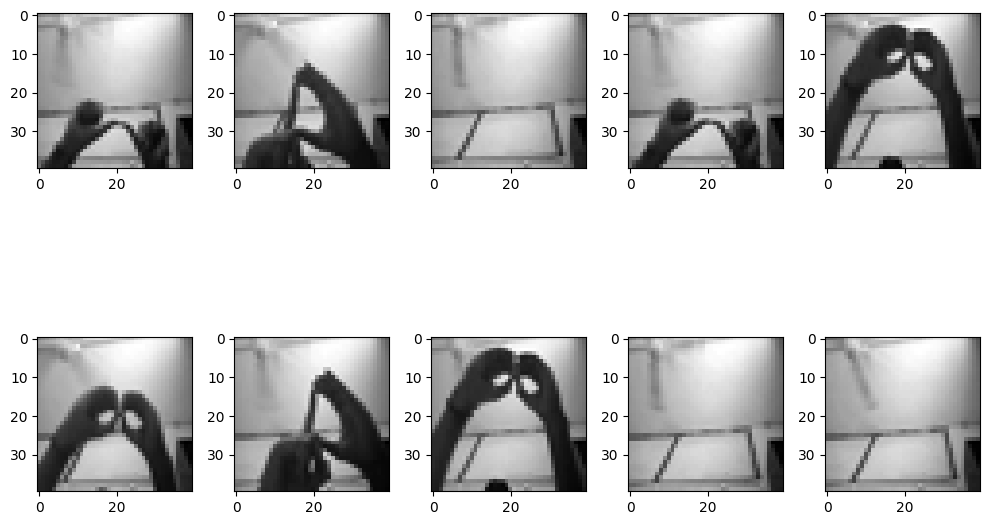

In [ ]:
import matplotlib.pyplot as plt
f, ax = plt.subplots(2,5)
f.set_size_inches(10, 10)
k = 0
for i in range(2):
    for j in range(5):
        ax[i,j].imshow(x_train[k].reshape(40, 40) , cmap = "gray")
        k += 1
    plt.tight_layout()

In [ ]:
x_train.shape

(446, 40, 40, 1)

In [ ]:
y_train.shape

(446, 5)

In [ ]:
# Define your model
model = Sequential([
    Conv2D(65, kernel_size=(3, 3), activation='relu', input_shape=(40, 40, 1)),
    MaxPooling2D(pool_size=(2, 2)),
    Conv2D(40, kernel_size=(3, 3), activation='relu'),
    Dropout(0.25),
    MaxPooling2D(pool_size=(2, 2)),
    Conv2D(25, kernel_size=(3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Flatten(),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(5, activation='softmax')  # for 5 classes
])

In [ ]:
# Compile the model
model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])


In [ ]:
# Print model summary
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 38, 38, 65)        650       
                                                                 
 max_pooling2d (MaxPooling2  (None, 19, 19, 65)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 17, 17, 40)        23440     
                                                                 
 dropout (Dropout)           (None, 17, 17, 40)        0         
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 8, 8, 40)          0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 6, 6, 25)          9

In [ ]:
y_train.shape

(446, 5)

In [ ]:
# Initialize ImageDataGenerator
datagen = ImageDataGenerator(
    featurewise_center=False,
    samplewise_center=False,
    featurewise_std_normalization=False,
    samplewise_std_normalization=False,
    zca_whitening=False,
    rotation_range=10,
    zoom_range=0.1,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=False,
    vertical_flip=False
)

In [ ]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy',
                                            patience=2,
                                            verbose=1,
                                            factor=0.5,
                                            min_lr=0.00001)

In [ ]:
history = model.fit(datagen.flow(x_train, y_train, batch_size=128),
                    steps_per_epoch=len(x_train) / 128,
                    epochs=20,
                    validation_data=(x_test, y_test),
                    callbacks=[learning_rate_reduction])

Epoch 1/20
3/3 [==============================] - 3s 511ms/step - loss: 1.5540 - accuracy: 0.3610 - val_loss: 1.4442 - val_accuracy: 0.7232 - lr: 0.0010
Epoch 2/20
3/3 [==============================] - 2s 439ms/step - loss: 1.3108 - accuracy: 0.5269 - val_loss: 1.1221 - val_accuracy: 0.8393 - lr: 0.0010
Epoch 3/20
3/3 [==============================] - 2s 443ms/step - loss: 0.9662 - accuracy: 0.7422 - val_loss: 0.6888 - val_accuracy: 0.9018 - lr: 0.0010
Epoch 4/20
3/3 [==============================] - 2s 609ms/step - loss: 0.6221 - accuracy: 0.8206 - val_loss: 0.3453 - val_accuracy: 0.9732 - lr: 0.0010
Epoch 5/20
3/3 [==============================] - 3s 849ms/step - loss: 0.4427 - accuracy: 0.8543 - val_loss: 0.2096 - val_accuracy: 0.9643 - lr: 0.0010
Epoch 6/20
4/3 [==================================] - ETA: 0s - loss: 0.3444 - accuracy: 0.8789
Epoch 6: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
3/3 [==============================] - 2s 632ms/step - loss: 0.

In [ ]:
# Evaluate the model
accuracy = model.evaluate(x_test, y_test)[1]
print("Accuracy of the model is - {:.2f}%".format(accuracy * 100))

4/4 [==============================] - 0s 20ms/step - loss: 0.0495 - accuracy: 0.9821
Accuracy of the model is - 98.21%


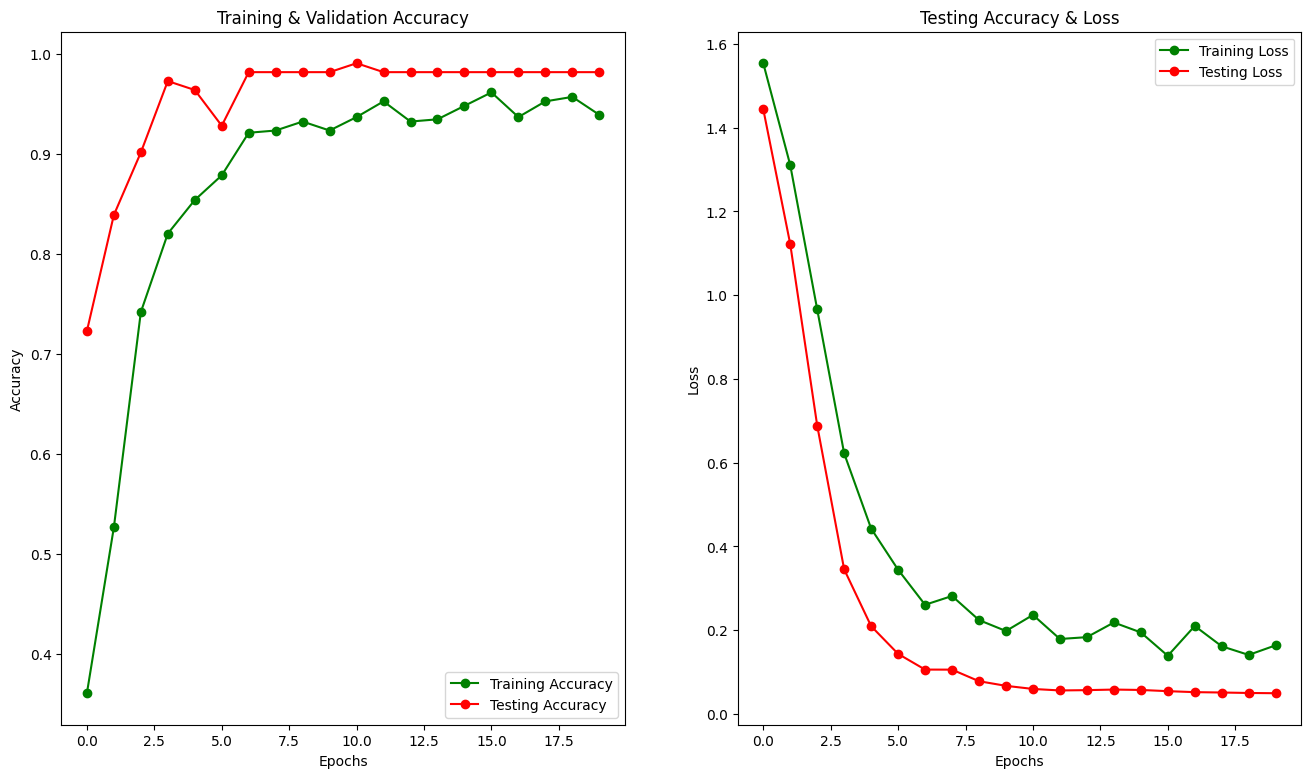

In [ ]:
epochs = [i for i in range(20)]
fig , ax = plt.subplots(1,2)
train_acc = history.history['accuracy']
train_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']
fig.set_size_inches(16,9)

ax[0].plot(epochs , train_acc , 'go-' , label = 'Training Accuracy')
ax[0].plot(epochs , val_acc , 'ro-' , label = 'Testing Accuracy')
ax[0].set_title('Training & Validation Accuracy')
ax[0].legend()
ax[0].set_xlabel("Epochs")
ax[0].set_ylabel("Accuracy")

ax[1].plot(epochs , train_loss , 'g-o' , label = 'Training Loss')
ax[1].plot(epochs , val_loss , 'r-o' , label = 'Testing Loss')
ax[1].set_title('Testing Accuracy & Loss')
ax[1].legend()
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("Loss")
plt.show()

In [ ]:
preds = model.predict(x_test)
predictions = np.argmax(preds, axis=1)
for i in range(len(predictions)):
    if(predictions[i] >= 9):
        predictions[i] += 1
predictions[:5]

4/4 [==============================] - 0s 32ms/step


array([0, 3, 0, 2, 1])

In [ ]:
# Save the model
model.save('sign_language_model.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
import tensorflow.compat.v1 as tf
# x_test_flat=tf.cast(tf.squeeze(x_test, axis=-1), tf.float32) / 255.0
x_test_flat=tf.cast(x_test, tf.float32)# / 255.0
print(x_test_flat.shape)
xtest_ds = tf.data.Dataset.from_tensor_slices((x_test_flat)).batch(1)

(112, 40, 40, 1)


In [ ]:
print(xtest_ds)
def representative_data_gen():
    for input_value in xtest_ds.take(100):
        yield [input_value]

<_BatchDataset element_spec=TensorSpec(shape=(None, 40, 40, 1), dtype=tf.float32, name=None)>


In [ ]:
def representative_dataset():
    xtest_rd = test_df.values
    for i in range(250):
        nxt = (xtest_rd[i])
        nxt = nxt.reshape(1,100,100,1)
        nxt = np.array(nxt)
        nxt = ((nxt/127.5)-1.0).astype(np.float32)
        yield([nxt])

In [ ]:
import tensorflow as tf

# Create a TFLiteConverter object from the Keras model
converter = tf.lite.TFLiteConverter.from_keras_model(model)

# Define the representative dataset function if needed
def representative_dataset():
    for data in tf.data.Dataset.from_tensor_slices(x_train).batch(1).take(100):
        yield [tf.dtypes.cast(data, tf.float32)]

# Optionally, set the representative dataset for quantization
converter.representative_dataset = representative_dataset

# Convert the model to the TFLite format
tflite_model = converter.convert()

# Save the TFLite model to a file
with open('model.tflite', 'wb') as f:
    f.write(tflite_model)


In [ ]:
def get_file_size(file_path):
    size = os.path.getsize(file_path)
    return size

In [ ]:
def convert_bytes(size, unit=None):
    if unit == "KB":
        return print('File size: ' + str(round(size / 1024, 3)) + ' Kilobytes')
    elif unit == "MB":
        return print('File size: ' + str(round(size / (1024 * 1024), 3)) + ' Megabytes')
    else:
        return print('File size: ' + str(size) + ' bytes')

In [ ]:
TF_LITE_MODEL_FILE_NAME = "ISL_lite.tflite"

In [ ]:
tf_lite_converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = tf_lite_converter.convert()

In [ ]:
tflite_model_name = TF_LITE_MODEL_FILE_NAME

In [ ]:
open("ISL_lite.tflite", "wb").write(tflite_model)

373100

In [ ]:
convert_bytes(get_file_size(TF_LITE_MODEL_FILE_NAME), "KB")

File size: 364.355 Kilobytes


In [ ]:
tflite_file_size = get_file_size(TF_LITE_MODEL_FILE_NAME)

In [ ]:
interpreter = tf.lite.Interpreter(model_path = TF_LITE_MODEL_FILE_NAME)
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()
print("Input Shape:", input_details[0]['shape'])
print("Input Type:", input_details[0]['dtype'])
print("Output Shape:", output_details[0]['shape'])
print("Output Type:", output_details[0]['dtype'])

Input Shape: [ 1 40 40  1]
Input Type: <class 'numpy.float32'>
Output Shape: [1 5]
Output Type: <class 'numpy.float32'>


In [ ]:
interpreter.resize_tensor_input(input_details[0]['index'], (10000, 40, 40, 3)) # Add a dimension for channels
interpreter.allocate_tensors()
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()
print("Input Shape:", input_details[0]['shape'])
print("Input Type:", input_details[0]['dtype'])
print("Output Shape:", output_details[0]['shape'])
print("Output Type:", output_details[0]['dtype'])

Input Shape: [10000    40    40     3]
Input Type: <class 'numpy.float32'>
Output Shape: [10000     5]
Output Type: <class 'numpy.float32'>


In [ ]:
x_test.dtype

dtype('float64')

In [ ]:
x_test_numpy = np.array(x_test, dtype=np.float32)

In [ ]:
x_test_numpy.dtype

dtype('float32')

In [ ]:
tflite_model_path = "ISL_lite.tflite"

# Load the TFLite model and allocate tensors.
interpreter = tf.lite.Interpreter(model_path=tflite_model_path)
interpreter.allocate_tensors()

# Get input and output tensors.
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

input_shape = input_details[0]['shape']
output_shape = output_details[0]['shape']
print(input_shape)
print(output_shape)

[ 1 40 40  1]
[1 5]


In [ ]:
nin = 600
nstrt = 1500

In [ ]:
interpreter.resize_tensor_input(input_details[0]['index'], (nin, 40, 40,1))
interpreter.resize_tensor_input(output_details[0]['index'], (nin, 24))
interpreter.allocate_tensors()
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()
print("Input Shape:", input_details[0]['shape'])
print("Input Type:", input_details[0]['dtype'])
print("Output Shape:", output_details[0]['shape'])
print("Output Type:", output_details[0]['dtype'])

Input Shape: [600  40  40   1]
Input Type: <class 'numpy.float32'>
Output Shape: [600   5]
Output Type: <class 'numpy.float32'>


In [ ]:
import numpy as np

# Create a placeholder for your input data. Replace this with your actual input data.
input_data_float32 = np.random.rand(2000, 40, 40, 1).astype(np.float32) # Example: random data

# Convert input data from float32 to int8 and reshape if necessary
input_data_int8 = (input_data_float32[nstrt:(nstrt+nin), :, :, :] * 127.5).astype(np.int8)

# Print the new shapes and types
print("Input Shape:", input_data_int8.shape)
print("Input Type:", type(input_data_int8))

Input Shape: (500, 40, 40, 1)
Input Type: <class 'numpy.ndarray'>


In [ ]:
x_test.shape

(112, 40, 40, 1)

In [ ]:
nin = 32
nstrt = 0

In [ ]:
# Get the actual number of samples in your test data
num_samples = x_test_numpy.shape[0]

# Resize the input tensor to match the number of samples in your test data
interpreter.resize_tensor_input(input_details[0]['index'], (num_samples, 40, 40, 1))
interpreter.allocate_tensors()

# Now set the tensor with your data
interpreter.set_tensor(input_details[0]['index'], x_test_numpy)
interpreter.invoke()


In [ ]:
from time import time

# Scale the images and convert to float32
test_imgs_numpy = np.array(x_test[nstrt:(nstrt+nin), :, :, :] * 127.5, dtype=np.float32)

# Set the input tensor with the float32 data
t1 = time()
interpreter.set_tensor(input_details[0]['index'], x_test_numpy)  # Now the data type matches
interpreter.invoke()
tflite_model_predictions = interpreter.get_tensor(output_details[0]['index'])
print((time()-t1)/nin)
print("Prediction results shape:", tflite_model_predictions.shape)
prediction_classes = np.argmax(tflite_model_predictions, axis=1)

0.006926193833351135
Prediction results shape: (112, 5)


In [ ]:
from sklearn.metrics import accuracy_score

# Calculate accuracy using prediction_classes and y_test
# Use the entire y_test array instead of slicing it
acc = accuracy_score(prediction_classes, np.argmax(y_test, axis=1))

# Print the test accuracy
print('Test accuracy TFLITE model:', acc)

Test accuracy TFLITE model: 0.9821428571428571


In [ ]:
TF_LITE_MODEL_FLOAT_16_FILE_NAME = "tf_lite_float_16_model.tflite"

In [ ]:
tf_lite_converter = tf.lite.TFLiteConverter.from_keras_model(model)
tf_lite_converter.optimizations = [tf.lite.Optimize.DEFAULT]
tf_lite_converter.target_spec.supported_types = [tf.float16]
tflite_model = tf_lite_converter.convert()

In [ ]:
tflite_model_name = TF_LITE_MODEL_FLOAT_16_FILE_NAME
open(tflite_model_name, "wb").write(tflite_model)

190000

In [ ]:
convert_bytes(get_file_size(TF_LITE_MODEL_FLOAT_16_FILE_NAME), "KB")

File size: 185.547 Kilobytes


In [ ]:
tflite_float_16_file_size = get_file_size(TF_LITE_MODEL_FLOAT_16_FILE_NAME)

In [ ]:
TF_LITE_SIZE_QUANT_MODEL_FILE_NAME = "tf_lite_quant_model.tflite"

In [ ]:
tf_lite_converter = tf.lite.TFLiteConverter.from_keras_model(model)
tf_lite_converter.optimizations = [tf.lite.Optimize.OPTIMIZE_FOR_SIZE]
tflite_model = tf_lite_converter.convert()

In [ ]:
tflite_model_name = TF_LITE_SIZE_QUANT_MODEL_FILE_NAME
open(tflite_model_name, "wb").write(tflite_model)

100216

In [ ]:
convert_bytes(get_file_size(TF_LITE_SIZE_QUANT_MODEL_FILE_NAME), "KB")

File size: 97.867 Kilobytes


In [ ]:
tflite_float_quant_file_size = get_file_size(TF_LITE_SIZE_QUANT_MODEL_FILE_NAME)

In [ ]:
interpreter = tf.lite.Interpreter(model_path = TF_LITE_SIZE_QUANT_MODEL_FILE_NAME)
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()
print("Input Shape:", input_details[0]['shape'])
print("Input Type:", input_details[0]['dtype'])
print("Output Shape:", output_details[0]['shape'])
print("Output Type:", output_details[0]['dtype'])

Input Shape: [ 1 40 40  1]
Input Type: <class 'numpy.float32'>
Output Shape: [1 5]
Output Type: <class 'numpy.float32'>


In [ ]:
# Load the TFLite model and allocate tensors.
interpreter = tf.lite.Interpreter(model_path=TF_LITE_SIZE_QUANT_MODEL_FILE_NAME)
interpreter.allocate_tensors()

# Get input and output tensors.
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

# Read the image file
image_path = "/content/drive/MyDrive/Project/Indian Sign Language/data/d/D10.jpg"
image_data = tf.io.read_file(image_path)
image = tf.image.decode_jpeg(image_data, channels=1)

# Resize and normalize the image
image = tf.image.resize(image, [40, 40])
image = tf.cast(image, tf.float32) / 127.5 - 1.0

# Add a batch dimension
image = tf.expand_dims(image, axis=0)

# Set the input tensor
interpreter.set_tensor(input_details[0]['index'], image)

# Run the interpreter
interpreter.invoke()

# Get the output tensor
output_data = interpreter.get_tensor(output_details[0]['index'])

# Get the predicted class
predicted_class = np.argmax(output_data)

if predicted_class == 1:
    predicted_gesture = "A"
elif predicted_class == 2:
    predicted_gesture = "B"
elif predicted_class == 3:
    predicted_gesture = "C"
elif predicted_class == 4:
    predicted_gesture = "D"
elif predicted_class == 0:
    predicted_gesture = "Empty"

# Print the predicted class
print("Predicted gesture:", predicted_gesture)


Predicted gesture: B


In [ ]:
# Correctly resize the input tensor, keeping the batch dimension
interpreter.resize_tensor_input(input_details[0]['index'], (1, 40, 40, 1))  # Assuming 1 channel as before

# Allocate tensors after resizing
interpreter.allocate_tensors()

# Get the input and output details
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()
print("Input Shape:", input_details[0]['shape'])
print("Input Type:", input_details[0]['dtype'])
print("Output Shape:", output_details[0]['shape'])
print("Output Type:", output_details[0]['dtype'])

Input Shape: [ 1 40 40  1]
Input Type: <class 'numpy.float32'>
Output Shape: [1 5]
Output Type: <class 'numpy.float32'>


In [ ]:
x_test.dtype

dtype('float64')

In [ ]:
test_imgs_numpy = np.array(x_test, dtype=np.float32)

In [ ]:
test_imgs_numpy.dtype

dtype('float32')

In [ ]:
# Get the actual number of samples in your test data
num_samples = test_imgs_numpy.shape[0]

# Resize the input tensor to match the number of samples in your test data
interpreter.resize_tensor_input(input_details[0]['index'], (num_samples, 40, 40, 1))
interpreter.allocate_tensors()

# Now set the tensor with your data
interpreter.set_tensor(input_details[0]['index'], x_test_numpy)
interpreter.invoke()


In [ ]:
tflite_model_predictions = interpreter.get_tensor(output_details[0]['index'])
print("Prediction results shape:", tflite_model_predictions.shape)
prediction_classes = np.argmax(tflite_model_predictions, axis=1)

Prediction results shape: (112, 5)


In [ ]:
acc = accuracy_score(prediction_classes, np.argmax(y_test, axis=1))

In [ ]:
print('Test accuracy TFLITE Quantized model is {}%'.format(round(100*acc, 2)))

Test accuracy TFLITE Quantized model is 98.21%
